In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Section 1: Define Tickers and Time Range

In [3]:
end = dt.datetime.now()
start = dt.datetime(2015,1,1)
tickers = ["BHARTIARTL.NS","HDFCBANK.NS","ICICIBANK.BO","RELIANCE.NS","TCS.NS"]

In [4]:
# Download Close Price

In [5]:
df = yf.download(["BHARTIARTL.NS","HDFCBANK.NS","ICICIBANK.BO","RELIANCE.NS","TCS.NS"],start,end)
Close = df.Close
Close.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_98016\1111147862.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(["BHARTIARTL.NS","HDFCBANK.NS","ICICIBANK.BO","RELIANCE.NS","TCS.NS"],start,end)
[*********************100%***********************]  5 of 5 completed


Ticker,BHARTIARTL.NS,HDFCBANK.NS,ICICIBANK.BO,RELIANCE.NS,TCS.NS
Date,,,,,
2015-01-01,308.073517,212.546021,293.033234,189.999802,1073.510498
2015-01-02,309.898743,215.504089,301.258514,189.496933,1087.806641
2015-01-05,303.022491,213.684586,301.673920,187.421249,1071.275024
2015-01-06,300.645508,210.358154,289.003784,178.915207,1031.781372
2015-01-07,301.367096,210.972107,281.401703,182.809799,1019.593201


In [6]:
# Calculate Lognormal Returns

In [7]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns

Ticker,BHARTIARTL.NS,HDFCBANK.NS,ICICIBANK.BO,RELIANCE.NS,TCS.NS
Date,,,,,
2015-01-02,0.005907,0.013821,0.027683,-0.002650,0.013229
2015-01-05,-0.022439,-0.008479,0.001378,-0.011014,-0.015314
2015-01-06,-0.007875,-0.015689,-0.042907,-0.046447,-0.037563
2015-01-07,0.002397,0.002914,-0.026657,0.021534,-0.011883
2015-01-08,0.017175,0.020788,0.024930,-0.014443,0.010738
...,...,...,...,...,...
2025-08-20,0.009745,-0.001458,-0.004291,-0.005012,0.026953
2025-08-21,0.000778,0.001508,0.010814,0.008316,0.001290
2025-08-22,0.001760,-0.013449,-0.006662,-0.011009,-0.015788


In [8]:
# Calculate the Covariance Matrix

In [9]:
cov_matrix = log_returns.cov()*252
cov_matrix

Ticker,BHARTIARTL.NS,HDFCBANK.NS,ICICIBANK.BO,RELIANCE.NS,TCS.NS
Ticker,,,,,
BHARTIARTL.NS,0.087331,0.018774,0.026954,0.022734,0.012506
HDFCBANK.NS,0.018774,0.050403,0.035910,0.024319,0.012824
ICICIBANK.BO,0.026954,0.035910,0.095332,0.031483,0.015268
RELIANCE.NS,0.022734,0.024319,0.031483,0.075146,0.017583
TCS.NS,0.012506,0.012824,0.015268,0.017583,0.054411


In [10]:
# Define Portfolio Performance Metrics

In [11]:
# 1). Calculate the portfolio standard deviation

In [12]:
def std_dev(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [13]:
# 2). Calculate the expected return

In [14]:
def exp_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [15]:
# 3). Calculate the Sharpe Ratio

In [16]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(exp_return(weights, log_returns) - risk_free_rate) / std_dev(weights, cov_matrix)

In [17]:
# Portfolio Optimization

In [18]:
# Set the risk-free rate

In [19]:
risk_free_rate = 0.058

In [20]:
# Define the function to minimize (negative Sharpe Ratio)

In [21]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [22]:
constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
bounds = [(0, 1) for _ in range(len(tickers))]

In [23]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [24]:
# Optimize the weights to maximize Sharpe Ratio

In [25]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method= "SLSQP", constraints=constraints, bounds=bounds)

In [26]:
# Get the optimal weights

In [27]:
optimal_weights = optimized_results.x

In [28]:
# Analyze the Optimal Portfolio

In [29]:
# Display analytics of the optimal portfolio

In [30]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}:{weight:.4f}")

print()

optimal_portfolio_return = exp_return(optimal_weights, log_returns)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")


Optimal Weights:
BHARTIARTL.NS:0.2718
HDFCBANK.NS:0.3821
ICICIBANK.BO:0.0000
RELIANCE.NS:0.3461
TCS.NS:0.0000

Expected Annual Return: 0.1740
Expected Volatility: 0.1934
Sharpe Ratio: 0.5996


In [31]:
# Display the final portfolio in a plot

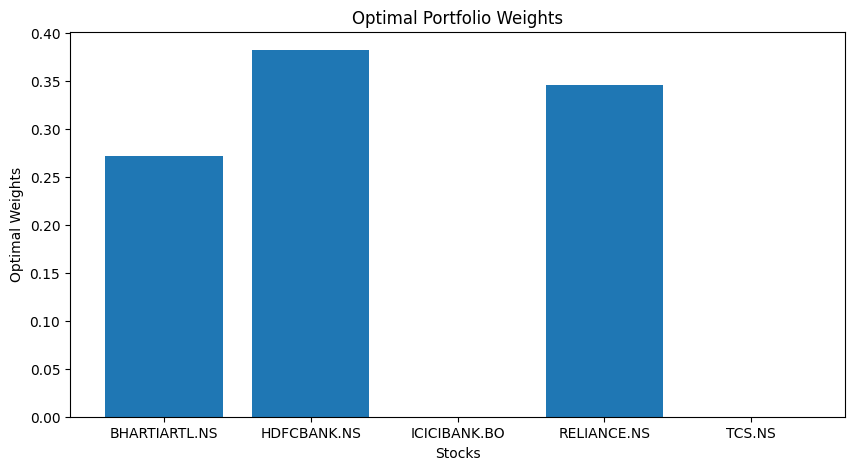

In [32]:
plt.figure(figsize=(10,5))
plt.bar(tickers, optimal_weights)

plt.xlabel("Stocks")
plt.ylabel("Optimal Weights")
plt.title("Optimal Portfolio Weights")
plt.savefig("my_chart.pdf")

plt.show()